# Phase Behaviors of Block Copolymers via Polyorder.jl and Related Packages - Part 1

## Quick Setup

### Installing Packages

Currently, Polyorder.jl and its dependent packages are private repositories hosted at https://github.com/liuyxpp, which are not registered in the Julia General Registry:

- PolymerArchitechture.jl
- Scattering.jl
- PhaseDiagram.jl

It is recommended to install them via [the private registry](https://github.com/liuyxpp/lab3083). First, you need to add the private registry to the Julia package manager in REPL:

```julia
(@v1.10) pkg> registry add git@github.com:liuyxpp/lab3083.git
```

or

```julia
(@v1.10) pkg> registry add https://github.com/liuyxpp/lab3083.git
```

This step only has to be done once. You can now install packages in both the General registry and the lab3083 registry. The dependent packages will be installed automatically just as installing packages normally.

Install all following packages to your project environment via:

```julia
(@v1.10) pkg> activate .
(your_project_dir) pkg> add Polymer PolymerArchitecture PolymerArchitectureMakie Scattering Polyorder PhaseDiagram
```

The environment `your_project_dir` can be any name you like. Make sure that

- Polymer.jl (v0.8.11+)
- PolymerArchitecture (v0.3.6+)
- Scattering.jl (v0.4.4+)
- Polyorder.jl (v0.23.0+)
- PhaseDiagram.jl (v0.8.2+)
- PolymerArchitectureMakie (v0.3.0+)

which can be checked via

```julia
(your_project_dir) pkg> st
```

To perform stress-guided cell optimization and compute stability limit via RPA, two extra packages are required:

```julia
(your_project_dir) pkg> add Optim Roots
```

Other packages required by this tutorial are registered in the General Registry, and can be installed via

```julia
(your_project_dir) pkg> add CairoMakie LaTeXStrings
```

### Loading Packages

In the notebook, we first activate the environment reside in the folder you start Pluto. This step will disable the Pluto built-in package manager. If you are not in Pluto notebook, you should use an appropriate way to activate current environment.

In [160]:
import Pkg
Pkg.activate(".")

using Polymer
using Scattering
using Polyorder
import Polyorder as JP
using PhaseDiagram
using PolymerArchitectureMakie
using CairoMakie
using LaTeXStrings

  Activating project at `~/SynologyDrive/Develop/Polyorder.jl/docs/tutorial`


In [161]:
# Suppressing displaying source code file location for @info
using Logging
global_logger(ConsoleLogger())

ConsoleLogger(IOBuffer(data=UInt8[...], readable=false, writable=false, seekable=false, append=false, size=0, maxsize=0, ptr=1, mark=-1), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [162]:
include("common.jl")

plot_density (generic function with 3 methods)

## Create Polymer Systems

Polyorder performs computations on a `PolymerSystem` object which is created by the Polymer.jl package.

A `PolymerSystem` object contains `BlockCopolymer` and/or `SmallMolecule` objects.

### Polymers and small molecules

#### Small molecules

Small molecules can be created by

In [163]:
SmallMolecule(:S)  # :S is the label/name of the samll molecule.

SmallMolecule S with b=1.0

Or you can use the handy method

In [164]:
solvent()  # the default label is :S

SmallMolecule S with b=1.0

#### Polymers

Polymer.jl currently only supports creating neat polymers and block copolymers, which are represented by a `BlockCopolymer` object. `BlockCopolymer` internally uses a graph to represent the chain architecture.

In Polymer.jl, a `BlockCopolymer` are consisted of `PolymerBlock`s, each of which is consisted of `KuhnSegment`s, and they are connected by `BranchPoints`. They may also have `FreeEnd`s.

A method for creating following polymer chain

```
[A1] - [B] - [A2] - [C1]
     	 |   	|
     	 [C2]  	[D]
```

Note that the two brackets around each block stand for two ends of that block.

In [165]:
function chainABCACD()
	# The chain has four distinct Kuhnsegments.
    sA = KuhnSegment(:A)
    sB = KuhnSegment(:B)
    sC = KuhnSegment(:C)
    sD = KuhnSegment(:D)
	# Among all block ends, there are three branch points and four free ends.
    eb1 = BranchPoint(:EB1)
    eb2 = BranchPoint(:EB2)
    eb3 = BranchPoint(:EB3)
	# The order of two ends is irrelevant 
    A1 = PolymerBlock(:A1, sA, 0.2, FreeEnd(:A1), eb1)
    B = PolymerBlock(:B, sB, 0.3, eb1, eb2)
    A2 = PolymerBlock(:A2, sA, 0.3, eb2, eb3)
    C1 = PolymerBlock(:C1, sC, 0.1, eb3, FreeEnd(:C1))
    C2 = PolymerBlock(:C2, sC, 0.05, eb2, FreeEnd(:C2))
    D = PolymerBlock(:D, sD, 0.05, eb3, FreeEnd(:D))
	# The order of these blocks is also irrelevant
    return BlockCopolymer(:ABCACD, [A1, B, A2, C1, C2, D])
end

chainABCACD (generic function with 1 method)

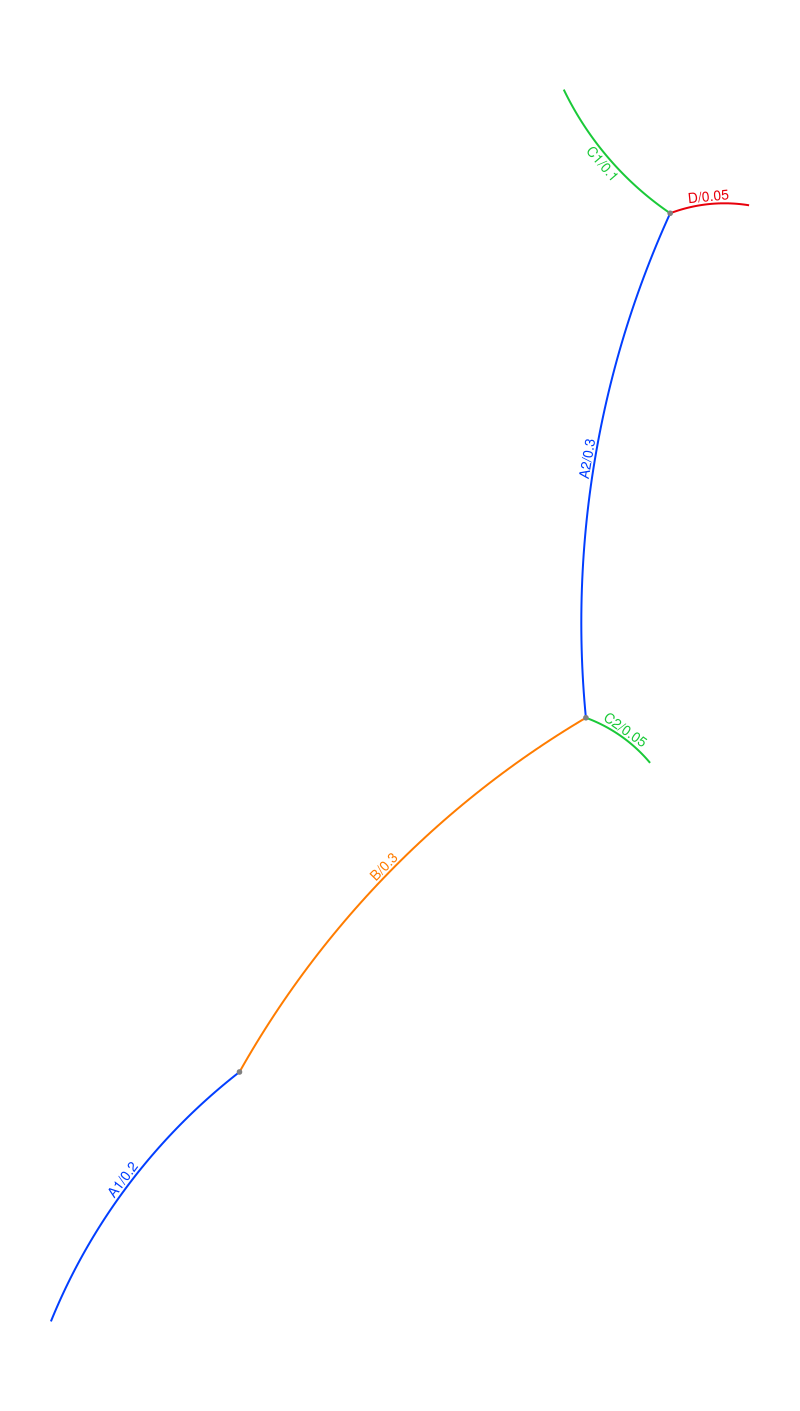

In [166]:
chainABCACD()

#### Exercises

1. Write a function that creates a AB3 star block copolymer

```
  [B1]
  |
[A] - [B2]
  |
  [B3]
```

2. Write a function that creates the following block copolymer

```
    [A2]         [B2]
       |         |
[A3] - [B1] - [A1] - [B3]
       |         |
    [A4]         [B4]
```

### Polymer systems

Before adding `BlockCopolymer` or `SmallMolecule` objects to `PolymerSystem`, we have to wrap each of them into a `Component` struct. A `Component` object carries extra information such as its volume fraction and its reference length.

In [167]:
AB_system()  # χN and fA can be specified by the keyword arguments

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.5 of specie A
  * PolymerBlock B with f=0.5 of specie B
, 1.0, 1.0)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
, 1.0)

In [168]:
ABC_system()

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer ABC with 3 blocks:
  * PolymerBlock A with f=0.3 of specie A
  * PolymerBlock B with f=0.4 of specie B
  * PolymerBlock C with f=0.29999999999999993 of specie C
, 1.0, 1.0)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, C) => 40.0
    (B, C) => 40.0
    (A, B) => 40.0
, 1.0)

For any block copolymer melts, we can use the `PolymerSystem` constructor:

In [169]:
let
	chain = chainABCACD()  # Create a polymer chain
	polymer = Component(chain)  # Wrap the chain into a component
	# Create an interaction map between different species
	χNmap = Dict([:A, :B]=>10.0,
				 [:A, :C]=>20.0,
				 [:A, :D]=>30.0,
				 [:B, :C]=>40.0,
				 [:B, :D]=>50.0,
				 [:C, :D]=>60.0
	)
	PolymerSystem([polymer], χNmap)  # Create a polymer system
end

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer ABCACD with 6 blocks:
  * PolymerBlock A1 with f=0.2 of specie A
  * PolymerBlock B with f=0.3 of specie B
  * PolymerBlock A2 with f=0.3 of specie A
  * PolymerBlock C1 with f=0.1 of specie C
  * PolymerBlock C2 with f=0.05 of specie C
  * PolymerBlock D with f=0.05 of specie D
, 1.0, 1.0)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (D, B) => 50.0
    (A, C) => 20.0
    (B, C) => 40.0
    (A, B) => 10.0
    (A, D) => 30.0
    (D, C) => 60.0
, 1.0)

#### A/B binary blend

First, we create two homopolymers chainA and chainB via the convenient function `homopolymer_chain` of Polymer.jl.

In [170]:
chainA = homopolymer_chain(label=:A)
chainB = homopolymer_chain(label=:B)
nothing

Then we wrap them into two `Component` objects. Below, we make them equal length and equal volume fraction.

In [171]:
polymerA = Component(chainA, 1.0, 0.5)  # αA = 1.0, ϕA = 0.5
polymerB = Component(chainB, 1.0, 0.5)  # αB = 1.0, ϕB = 0.5

Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer B with 1 blocks:
  * PolymerBlock B with f=1.0 of specie B
, 1.0, 0.5)

Next, we will specify the interactions via a `Dict` object:

In [172]:
χNmap = Dict([:A, :B]=>20.0)  # requires Polymer.jl v0.8.5

Dict{Vector{Symbol}, Float64} with 1 entry:
  [:A, :B] => 20.0

Finally, we can construct a `PolymerSystem` object for a A/B binary blend:

In [173]:
PolymerSystem([polymerA, polymerB], χNmap)

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer A with 1 blocks:
  * PolymerBlock A with f=1.0 of specie A
, 1.0, 0.5), Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer B with 1 blocks:
  * PolymerBlock B with f=1.0 of specie B
, 1.0, 0.5)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
, 1.0)

Note that a convenient function `A_B_system` has been provide by Polymer.jl to do exactly the above things.

In [174]:
A_B = A_B_system()

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer A with 1 blocks:
  * PolymerBlock A with f=1.0 of specie A
, 1.0, 0.5), Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer B with 1 blocks:
  * PolymerBlock B with f=1.0 of specie B
, 1.0, 0.5)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
, 1.0)

#### AB/A binary blend

This can be done via the function `AB_A_system` provided by the package `Polymer.jl`.

`AB_A_system` accepts keyword arguments only. Its signature is

```julia
AB_A_system(; χN=20.0, ϕAB=0.5, fA=0.5, α=0.5)
```

The following is assumed:

* `αAB = 1.0`
* `αA = α`
* `fA` is the length fraction of A block within the AB block copolymer.

Below we create a binary blend which is the same as that in Fig. 3 of Ref. Mester, Z.; Lynd, N. A.; Fredrickson, G. H. Numerical Self-Consistent Field Theory of Multicomponent Polymer Blends in the Gibbs Ensemble. Soft Matter 2013, 9 (47), 11288.

In [175]:
AB_A = AB_A_system(; χN=10.0, fA=0.45, α=1.0)  # function from Polymer.jl

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.45 of specie A
  * PolymerBlock B with f=0.55 of specie B
, 1.0, 0.5), Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer hA with 1 blocks:
  * PolymerBlock hA with f=1.0 of specie A
, 1.0, 0.5)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, B) => 10.0
, 1.0)

#### AB/A/B ternary blend

Based on Polymer.jl, arbitrary polymer blends including polymer solutions can be created. Below is an example on how to create an AB/A/B ternary blend.

In [176]:
function AB_A_B_system(; χN=20.0, ϕAB=0.5, fA=0.5, ϕA=0.25, αA=0.5, αB=0.5)
    AB = Component(diblock_chain(fA=fA), 1.0, ϕAB)
    A = Component(homopolymer_chain(label=:hA, segment=KuhnSegment(:A)), αA, ϕA)
	B = Component(homopolymer_chain(label=:hB, segment=KuhnSegment(:A)), αB, 1-ϕAB-ϕA)
    return PolymerSystem([A, B, AB], Dict([:A, :B]=>χN))
end

AB_A_B_system (generic function with 1 method)

*Note that we put `AB` as the last component in the `PolymerSystem` object, which follows literature convention so that chemical related properties are reduced quantities using the last component as a reference.*

In [177]:
AB_A_B = AB_A_B_system()

PolymerSystem{Float64}(Component[Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer hA with 1 blocks:
  * PolymerBlock hA with f=1.0 of specie A
, 0.5, 0.25), Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer hB with 1 blocks:
  * PolymerBlock hB with f=1.0 of specie A
, 0.5, 0.25), Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.5 of specie A
  * PolymerBlock B with f=0.5 of specie B
, 1.0, 0.5)], BulkConfinement(), Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
, 1.0)

#### Exercises

1. Create a block copolymer melt system contains a miktoarm chain AB3. The interaction between A and B is 30.0.

2. Create a AB3/A binary blend. The volume fraction of homopolymer A is 0.1. The reference length is the length of AB3, and the length of homopolymer A is 0.2. The interaction between A and B is 30.0.

## Create Simulation Cell

A polymer system has to be put in a simulation cell, which carries the information about the cell size, shape and symmetry. A simulation cell is a `Scattering.BravaisLattice` object.

### Unit cells and crystal systems

Scattering.jl supports all crystal systems in 1D, 2D and 3D. A full list can be viewed by running:

In [178]:
values(Scattering.Crystal.ALL_CRYSTAL_SYSTEMS)

ValueIterator for a Dict{Tuple{Symbol, Symbol, Vararg{Symbol}}, DataType} with 14 entries. Values:
  Oblique
  Hexagonal
  Rectangular
  HexRect
  Line
  Hexagonal2D
  Triclinic
  Orthorhombic
  HexOrthorhombic
  Square
  Cubic
  Tetragonal
  Trigonal
  Monoclinic

Unit cell can be created by the `UnitCell` constructor function. One way is to specify crystal system and corresponding crystalline parameters.

In [179]:
UnitCell(Cubic(), 4.0)  # create a cubic cell

UnitCell
  * Crystal system: Cubic
  * Edges: [4.0, 4.0, 4.0]
  * Angles: [π/2, π/2, π/2]


Another way is to specify edge lengths and angles. If angles are ignored, they are assumed to be $\pi/2$. The crystal system is inferred from the edge lengths and angles.

In [180]:
let
	uc = UnitCell((2.0, 3.0, 4.0))
	crystalsystem(uc)
end

Orthorhombic crystal system with free lattice parameters [a, b, c]

### Space Group

- For 1D crystals, there are two space groups.
- For 2D crystals, there are 17 space groups.
- For 3D crystals, there are 230 space groups.

These space groups can be described by the `SpaceGroup` struct defined in Crystalline.jl package. They can be created by specifying the space group index and the number of space dimension. For the name of each space group, please check out the list [here](https://en.wikipedia.org/wiki/List_of_space_groups).

In [181]:
spacegroup(70, 3)  # O70 (Fddd) space group

SpaceGroup{3} ⋕70 (Fddd) with 32 operations:
 1
 {2₀₀₁|¾,¾,0}
 {2₀₁₀|¾,0,¾}
 {2₁₀₀|0,¾,¾}
 -1
 {m₀₀₁|¼,¼,0}
 {m₀₁₀|¼,0,¼}
 {m₁₀₀|0,¼,¼}
 {1|0,½,½}
 {2₀₀₁|¾,¼,½}
 {2₀₁₀|¾,½,¼}
 {2₁₀₀|0,¼,¼}
 {-1|0,½,½}
 {m₀₀₁|¼,¾,½}
 {m₀₁₀|¼,½,¾}
 {m₁₀₀|0,¾,¾}
 {1|½,0,½}
 {2₀₀₁|¼,¾,½}
 {2₀₁₀|¼,0,¼}
 {2₁₀₀|½,¾,¼}
 {-1|½,0,½}
 {m₀₀₁|¾,¼,½}
 {m₀₁₀|¾,0,¾}
 {m₁₀₀|½,¼,¾}
 {1|½,½,0}
 {2₀₀₁|¼,¼,0}
 {2₀₁₀|¼,½,¾}
 {2₁₀₀|½,¼,¾}
 {-1|½,½,0}
 {m₀₀₁|¾,¾,0}
 {m₀₁₀|¾,½,¼}
 {m₁₀₀|½,¾,¼}

### Lattice

A simulation cell can be created by specifying the unit cell only. The crystal system is inferred from the unit cell. The space group is chosen to be the first space group of that crystal system.

In [182]:
let
	uc = UnitCell((2.0, 3.0, 4.0))
	BravaisLattice(uc)
end

BravaisLattice
  * Centering: P
  * Space group: #16 (P222)
  * Crystal system: Orthorhombic
  * Unit cell: [2.0, 3.0, 4.0] [π/2, π/2, π/2]
  * Free lattice parameters: [a, b, c]


Alternatively, the space group can be specified explicitly as

In [183]:
let
	uc = UnitCell(Orthorhombic(), 2.0, 3.0, 4.0)
	BravaisLattice(uc, 40)  # No. 40 space group (3D) because uc is 3D.
end

BravaisLattice
  * Centering: A
  * Space group: #40 (Ama2)
  * Crystal system: Orthorhombic
  * Unit cell: [2.0, 3.0, 4.0] [π/2, π/2, π/2]
  * Free lattice parameters: [a, b, c]


An advanced usage of crystal system is to specify which unit cell parameters are fixed. The b edge length of following orthorhombic cell is fixed.

Note that `UnitCell` object does not explicitly carry any crystal system information. Thus control parameters cannot be set in `UnitCell`.

In [184]:
let
	uc = UnitCell((2.0, 3.0, 4.0))
	a = Scattering.Crystal.a
	c = Scattering.Crystal.c
	lat = BravaisLattice(uc, 40; freevars=[a, c])
end

BravaisLattice
  * Centering: A
  * Space group: #40 (Ama2)
  * Crystal system: Orthorhombic
  * Unit cell: [2.0, 3.0, 4.0] [π/2, π/2, π/2]
  * Free lattice parameters: [a, c]


### Exercises

1. Create a cubic cell with space group 230 and side length 5.0.

2. Create a 2D hexagonal cell with default space group and side length 3.0.

## Construct SCFT Models

An SCFT model holds all information needed for performing SCFT calculations. It typically includes:

- A `PolymerSystem` object: describing the polymer system
- A `BravaisLattice` object: describing the simulation cell
- An array of density fields
- An array of auxiliary fields
- An array of propagators
- An SCFT udpater
- An array of MDE solvers

Currently, Polyorder only supports non-cyclic chain architechures.

### Constructor

The model can be created by the constructor of `NoncyclicChainSCFT` struct as follows,

In [185]:
let
	uc = UnitCell(4.0)  # Create a unit cell
	lat = BravaisLattice(uc)  # Create a simulation cell
	system = AB_system()  # Create a diblock copolymer system
	ds = 0.01  # global contour step size for all blocks
	model = NoncyclicChainSCFT(system, lat, ds)  # Create the SCFT model
end

Noncyclic Chain SCFT model:
* Free energy: NaN
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.5 of specie A
  * PolymerBlock B with f=0.5 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [4.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (27,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: 0.03774 [-0.4403, 0.4405]


### Configurations

Note that density fields, auxiliary fields, and propagators are created automatically according to the given simulation cell. Other configurable parameters, such as spatial resolution is given by the default `Polyorder.Config()` instance. You can check out the default settings by create a default `Polyorder.Config` instance:

In [186]:
JP.Config()

Polyorder.Config(PolymerSystemConfig(nothing, SpecieConfig[SpecieConfig(:A, :Segment, 1.0, nothing), SpecieConfig(:B, :Segment, 1.0, nothing)], Vector{Any}[[:A, :B, 20.0]], ComponentConfig[ComponentConfig(:BCP, :AB, 1.0, 1.0, BlockConfig[BlockConfig(:A, :A, 0.5, [:AB]), BlockConfig(:B, :B, 0.5, [:AB])])], 1.0), LatticeConfig(CrystalSystemConfig(:Line, Symbol[]), :P, UnitCellConfig(1, 1.0, nothing, nothing, nothing, nothing, nothing), SpaceGroupConfig(1, 1)), IOConfig(1, false, false, ".", "summary", "trace", "fields", "densities", "config", :HDF5, true, true, true, true, true, 100, 1000, 1000, 6, 0), SCFTConfig(:SD, false, :simple, false, [0.1, 0.5], 0.02, 0.9, 1, 100, 2000, 100, 1, 0.5, :vecnormInf, :vecnormInf, false, 0.15, false, :Residual, 1.0e-5, 0.001, 1.0, 100, 1.4901161193847656e-8, 100, 1.0, 100, 1.4901161193847656e-8, 10, 10, false, false, false, false, false), MDEConfig(:RQM4, Symbol[], :Fixf, [0.01], Int64[]), CellOptConfig(Symbol("Optim.Brent"), Symbol("Optim.NelderMead"),

The default MDE solver is `RQM4`, and the default SCFT updater is `SD`. You can change them by passing them through keywords `mde` and `updater`, respectively:

In [187]:
let
	uc = UnitCell(4.0)  # Create a unit cell
	lat = BravaisLattice(uc)  # Create a simulation cell
	system = AB_system()  # Create a diblock copolymer system
	ds = 0.01  # global contour step size for all blocks
	# Create an SCFT model with the `OSF` MDE solver and the `SIS` updater.
	model = NoncyclicChainSCFT(system, lat, ds; mde=OSF, updater=SIS(0.1))
end

Noncyclic Chain SCFT model:
* Free energy: 719.9691247205
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.5 of specie A
  * PolymerBlock B with f=0.5 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 20.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [4.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (27,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: 1S semi-implicit method (SIS-1) with α=0.1.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: -0.08264 [-0.4875, 0.429]


Or equivalently, create a `Polymer.Config` instance with configured `mde` and `scft` fields:

In [188]:
let
	mde = MDEConfig(algo=:OSF)
	scft = SCFTConfig(algo=:Euler)
	
	config = JP.Config(mde=mde, scft=scft)
	
	# Create an SCFT model with the `OSF` MDE solver and the `Euler` updater.
	model = NoncyclicChainSCFT(config)

	model.updater isa Euler
end

true

It is useful to serialize SCFT models as a `Polyorder.Config`. Polyorder provides a function `to_config` to do it. And `save_config` to save the `Polyorder.Config` instance as an YAML file.

In [189]:
let
	uc = UnitCell(4.0)  # Create a unit cell
	lat = BravaisLattice(uc)  # Create a simulation cell
	system = AB_system()  # Create a diblock copolymer system
	ds = 0.01  # global contour step size for all blocks
	# Create an SCFT model with the `OSF` MDE solver and the `SIS` updater.
	model = NoncyclicChainSCFT(system, lat, ds; mde=OSF, updater=SIS(0.1))
	
	config = to_config(model, JP.Config())  # serialize a model as a Config object
	save_config("config.yml", config)  # save the Config object as an YAML file
end

### Exercises

1. Construct a SCFT model for a miktoarm block copolymer AB3 (fA=0.4, fB1=fB2=fB3=0.2), in a cubic unit cell with side length 4.0 Rg and space group No.230. 

2. Construct a SCFT model for a AB3/A binary blend (fA=0.4, fB1=fB2=fB3=0.2, choose AB3 as reference length, the length of homopolymer A is 0.5), in an orthorhombic unit cell with side length 3.0, 4.0, 5.0, respectively. Use RQM4 as MDE solver, ETD as updater. Set contour step for all A blocks (A in AB3 and A in hompolymer) to be 0.02, contour step for all B blocks to be 0.01.

3. Explore the source file `Polyorder.jl/src/config.jl`, and construct a configuration instance that set `symmetrize` to `false`, minimum and maximum number of iterations to be 50 and 500, respectively in `SCFTConfig`.

## Disordered (DIS) phase

The analytical solution at the mean-field level is available, which is the same as the Flory-Huggins lattice theory,

$\tilde{F} = \frac{F}{CV} = \sum_{X,Y}\chi_{XY}N \bar\phi_X \bar\phi_Y + \sum_i \frac{\phi_i}{\alpha_i}\left( \ln\frac{C\phi_i}{\alpha_i} - 1 \right)$

where $X, Y = \lbrace A, B, C, \dots \rbrace$ and $Y > X$ are the specie types in the polymer system, and $i = 1, 2, 3, \dots$ are the components in the polymer system. The averaging density for the specie X, $\bar\phi_X$, is

$\bar\phi_X = \sum_i\sum_j \delta_{XS_{ij}} f_{ij} \phi_i$

where $S_{ij}$ is the specie type in the $j$-th block of the $i$-th molecule, and $\delta_{XY}$ is the Kronecker delta function. Now we can compute its first-order partial derivative

$\frac{\partial\bar\phi_X}{\partial\phi_i} = \sum_j \delta_{XS_{ij}} f_{ij}$

Therefore,

$\gamma_i = \frac{\partial\tilde{F}}{\partial\phi_i} = \sum_{X,Y}\sum_j ( \delta_{XS_{ij}}\bar\phi_Y + \delta_{YS_{ij}}\bar\phi_X)\chi_{XY}N f_{ij} + \frac{1}{\alpha_i}\ln\frac{C\phi_i}{\alpha_i}$

and the chemical potential can be readily computed

$\tilde\mu_i = \gamma_i - \gamma_{n_c}$

for $i=1, 2, \dots, n_c$ with $n_c$ the number of components in the system.

Polyorder provides two ways to compute the disordered (homogeneous) phase: the analytical way and the numerical way.

### Free energy

Create a NoncyclicChainSCFT instance.

In [190]:
begin
	uc_dis = UnitCell(1.0)  # 1D unit cell with length 1.0 Rg
	lattice_dis = BravaisLattice(uc_dis)
	# Space resolution `spacing` Δx is set to be equal to the length of the unit cell to ensure only one grid point is generated.
	nccscft_dis = NoncyclicChainSCFT(AB_A, lattice_dis, 0.01; spacing=1.0, mde=OSF)
end

Noncyclic Chain SCFT model:
* Free energy: 719.9380956322
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB + hA) contains 2 components:

Component AB with ϕ=0.5 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.45 of specie A
  * PolymerBlock B with f=0.55 of specie B

Component hA with ϕ=0.5 and α=1.0 contains BlockCopolymer hA with 1 blocks:
  * PolymerBlock hA with f=1.0 of specie A


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 10.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [1.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (1,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF), Dict{Any, Any}((2 => 1) => OSF, (1 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.

It is not recommended to use `solve!` method to compute the DIS phase. But it is good for testing whether the implementation of a SCFT algorithm is correct. Note that, to ensure that the DIS phase is computed, the number of grid points must be set to 1 to suppress all possible inhomogeneous phases.

The numerical way only serves as a test tool to verify the correctness of a SCFT implementation.

In [191]:
JP.solve!(nccscft_dis)  # solve the SCFT model numerically

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 719.9380956322
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [1.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 9.27322710886358e-6
[ Info: Stop triggered by EarlyStopping.Threshold(1.0e-5) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 0.3006028194
[ Info: final loss: 9.27e-6
[ Info: final stress norm: 0.0
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [1.0]
└   * Angles: [0]
[ Info: iterations: 57
[ Info: time per iteration: 51 microseconds, 241 nanoseconds
[ Info: Run time: 00:00:00.00292075
[ Info: =============

Polyorder.Successful()

We can simply obtain the free energy (which includes the contribution from the ideal gas terms) by calling the `F` function on the *solved* `NoncyclicChainSCFT` object.

In [192]:
JP.F(nccscft_dis)  # Evaluate the free energy numerically

0.3006028194400594

Compute the enthalpy part of the Flory-Huggins free energy.

In [193]:
JP.enthalpy(nccscft_dis)  # Evaluate the enthalpy numerically

1.9937499999999984

In [194]:
JP.enthalpy_FH(nccscft_dis)  # Evaluate the enthalpy analytically using FH theory.

1.9937500000000001

Compute the entropy part (i.e., the ideal gas terms) of the Flory-Huggins free energy,

$\tilde{S} = -\tilde{F}_{ig} = \sum_i \frac{\phi_i}{\alpha_i}\left( \ln\frac{C\phi_i}{\alpha_i} - 1 \right)$

In [195]:
JP.entropy(nccscft_dis)  # Evaluate the entropy numerically

1.6931471805599392

In [196]:
JP.entropy_ig(nccscft_dis)  # Evaluate the entropy analytically using FH theory

1.6931471805599454

In [197]:
JP.F_ig(nccscft_dis)  # shoud = -S

-1.6931471805599454

We can combine these two parts to obtain the full Flory-Huggins free energy: F = H - TS.

In [198]:
JP.enthalpy_FH(nccscft_dis) - JP.entropy_ig(nccscft_dis) # should be equal to JP.F(nccscft_dis)

0.30060281944005474

A convenient function is provided in the Polyorder package to compute the Flory-Huggins free energy, which is `F_DIS` or `F_FH`. **Analytical expressions** are utilized to carry out the computation.

We can verify the accuracy of the DIS free energy calculated from SCFT equations:

In [199]:
JP.F_DIS(nccscft_dis) - JP.F(nccscft_dis)

-4.6629367034256575e-15

It is not necessary to create an `NoncyclicChainSCFT` object to compute the disordered phases. **Using `PolymerSystem` directly is the recommended way to compute the DIS free energy:**

In [200]:
JP.F_DIS(AB_A)

0.30060281944005474

In [201]:
JP.F_DIS(AB_A_B)

1.210279229160082

In [202]:
JP.F_DIS(A_B)

3.3068528194400546

### Chemical potential

Compute chemical potentials from the solved `NoncyclicChainSCFT` object.

In [203]:
JP.μ̃s(nccscft_dis)  # Evaluate the chemical potential numerically

1-element Vector{Float64}:
 2.4749897994501753

Compute chemical potentials based on Flory Huggins lattice theory.

In [204]:
JP.μ̃s_DIS(nccscft_dis)  # Evaluate the chemical potential analytically

1-element Vector{Float64}:
 2.4750000000000005

Verify the accuracy of the SCFT computation.

In [205]:
JP.μ̃s(nccscft_dis) .- JP.μ̃s_DIS(nccscft_dis)

1-element Vector{Float64}:
 -1.0200549825256644e-5

Similarly, **using `PolymerSystem` directly is the recommended way to compute the DIS chemical potential.**

In [206]:
# the modified chemical potentials for each component except the last one.
# the order of component is the same as the array `PolymerSystem.components`.
JP.μ̃s_DIS(AB_A)

1-element Vector{Float64}:
 2.4750000000000005

In [207]:
AB_A.components

2-element Vector{Component}:
 Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.45 of specie A
  * PolymerBlock B with f=0.55 of specie B
, 1.0, 0.5)
 Component{BlockCopolymer{PolymerBlock{Float64}}, Float64}(BlockCopolymer hA with 1 blocks:
  * PolymerBlock hA with f=1.0 of specie A
, 1.0, 0.5)

Thus the chemical potential is for the AB diblock copolymer in the above case.

In [208]:
JP.γs_DIS(AB_A_B)  # the partial derivatives for each component.

3-element Vector{Float64}:
 3.613705638880109
 3.613705638880109
 9.306852819440055

In [209]:
JP.μ̃s_DIS(AB_A_B)  # the modified chemical potentials for each component (AB and A) except the last one (B).

2-element Vector{Float64}:
 -5.693147180559945
 -5.693147180559945

In [210]:
JP.μs_DIS(AB_A_B)  # the chemical potentials for each component.

3-element Vector{Float64}:
 -0.8181471805599454
 -0.8181471805599454
  4.056852819440055

### Batch evaluations

Plot the free energy as a function of the volume fraction of the AB component for the AB/A binary blend.

In [211]:
begin
	system = AB_A_system(; χN=10.0, fA=0.45, α=1.0)
	ϕA_control = ϕControlParameter(:hA, system)  # a handle for modifying PolymerSystem
end

ϕControlParameter{Polymer.var"#30#32"}(2, ϕType{Float64}("volume fraction of a type of chain in a polymer system.", "ϕ", "phi", L"$\phi$", Float64, 0.0, 1.0, Float64[], Float64[]), Polymer.var"#30#32"())

In [212]:
begin
	ϕAs_dis = 0.001:0.001:0.999  # ϕA
	Fs_dis = similar(ϕAs_dis)
	μs_dis = similar(ϕAs_dis)
	for i in eachindex(ϕAs_dis)
		Polymer.update!(system, ϕAs_dis[i], ϕA_control)
		Fs_dis[i], μs_dis[i] = JP.F_DIS(system), JP.μ̃_DIS(system, 1)
	end
end

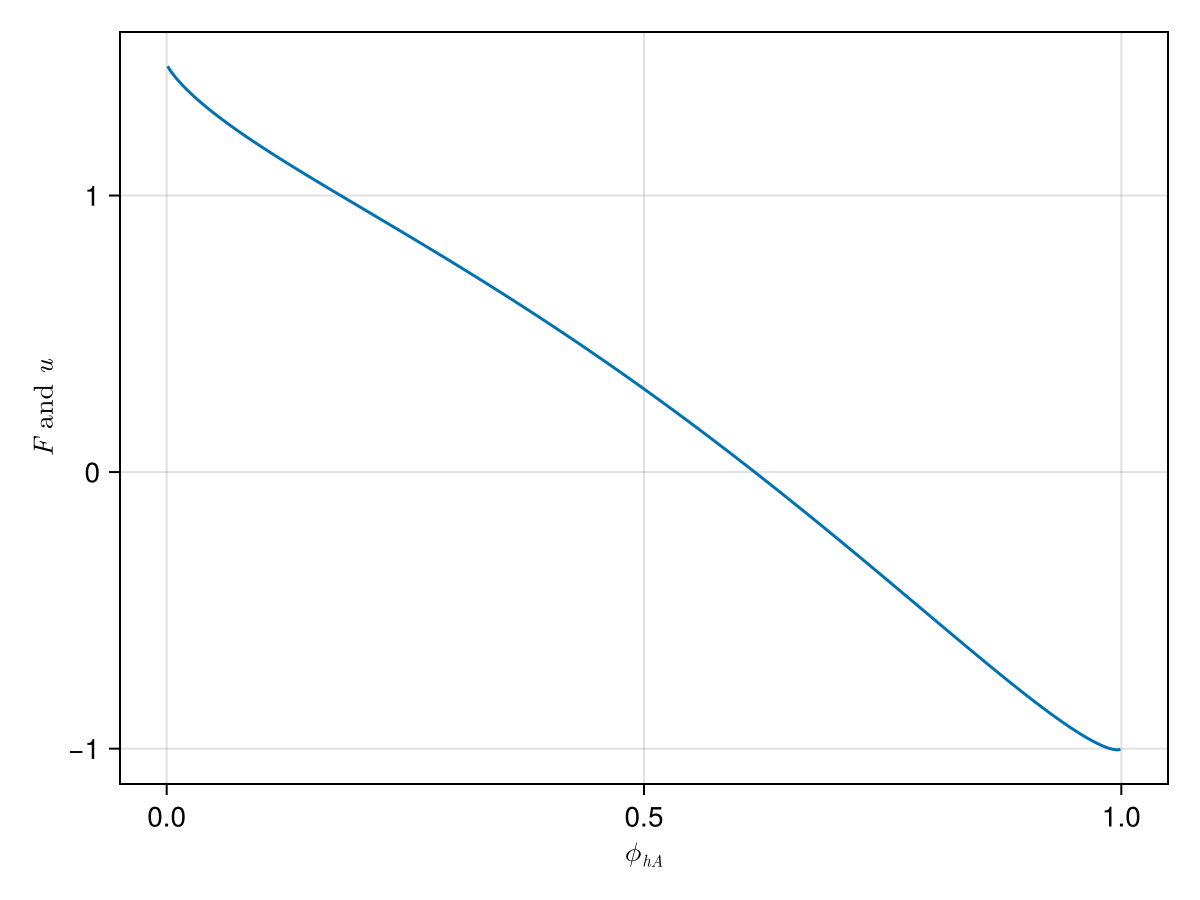

In [213]:
let
	f = Figure()
	ax = Axis(f[1, 1],
	    xlabel = L"$\phi_{hA}$",
	    ylabel = L"$F$ and $u$",
	)
	lines!(ax, ϕAs_dis, Fs_dis, label=L"$F$")
	f
end

A straight line is subtracted from the actual free energy curve to visualize the double-well structure more easily.

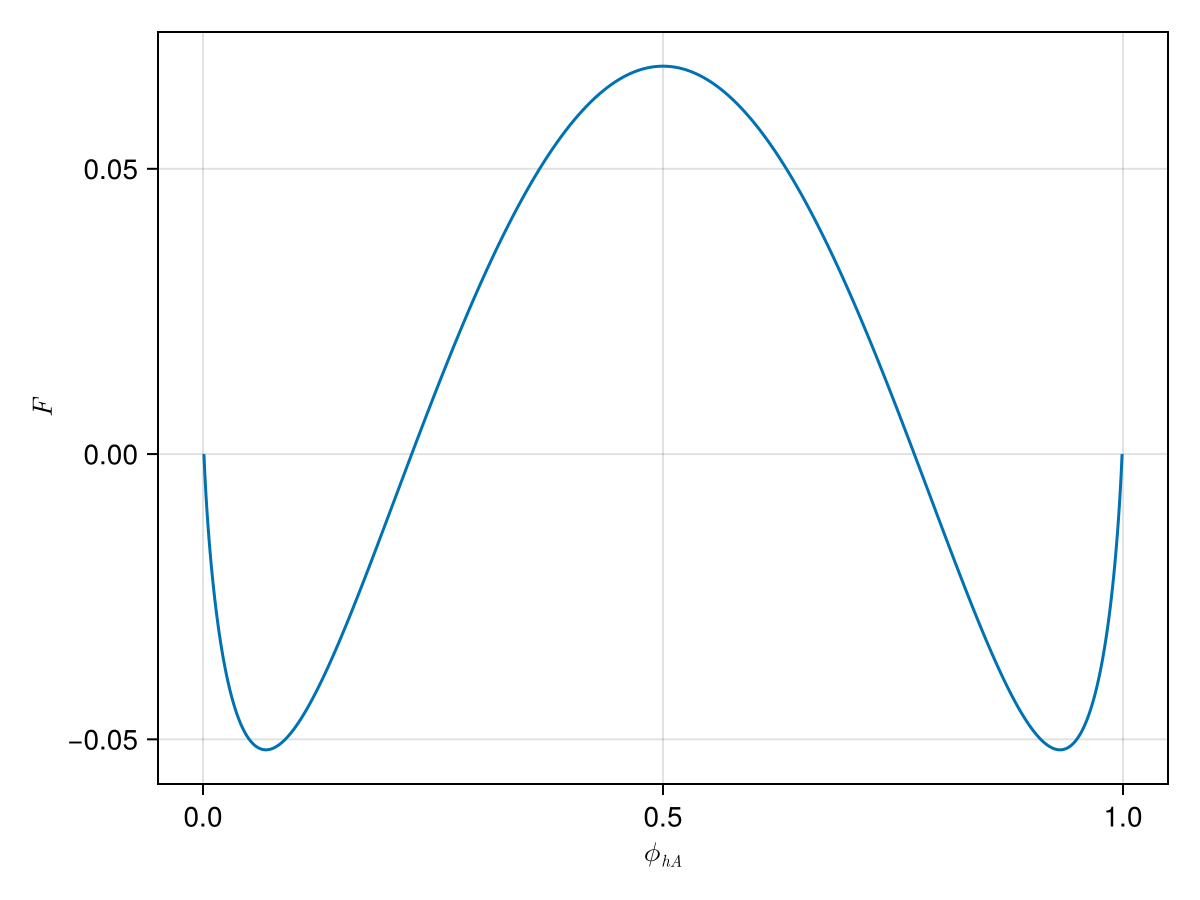

In [214]:
let
	line = get_line(ϕAs_dis[1], Fs_dis[1], ϕAs_dis[end], Fs_dis[end])
	F_sub = subtract_line(line, ϕAs_dis, Fs_dis)
	f = Figure()
	ax = Axis(f[1, 1],
	    xlabel = L"$\phi_{hA}$",
	    ylabel = L"$F$",
	)
	lines!(ax, ϕAs_dis, F_sub, label="DIS")
	f
end

### Exercises

1. Draw DIS phase free energy curves of the A/B binary blend for χN={1.5, 1.8, 1.99, 2.01, 2.1, 3.0}, and other values which are helpful to understand the trend of the change of these free energy curves.

## Ordered Phases

Block copolymers undergo a microphase separation when the interaction between species. Ordered phases emerges during the microphase separation. The ordered structures can be computed by SCFT numerically. Polyorder provides `solve!` and `cell_solve!` for fixed cell calculations and cell optimization, respectively.

Here, we use the most simple block copolymer system, AB diblock copolymer melt to demonstrate the usage of Polyorder.

### LAM

By restricting in the 1D unit cell, the only possible phases are LAM and DIS.

Sometimes, when $\chi N$ is significantly close to the critical point or the cell size significantly deviates from the equilibrium value, the DIS is computed instead of LAM. Therefore, for a rigorous approach, we must check the density distribution of the final solution to make sure the LAM is actually computed. Or, simply compared its free energy with the DIS phase, if they are close within a threshold (say 1e-8), we can conclude that the DIS instead of LAM is computed.

If DIS has been computed when the target phase is an ordered phase, we can

* make sure that $\chi N$ is indeed above the binodal line.
* change the cell size
* provide an initial density distribution with a larger variation.

In [215]:
scft_AB_lam = let
	ds = 0.01
	uc = UnitCell(3.0)
	lat = BravaisLattice(uc)
	system = AB_system(χN=15.0, fA=0.36)
	NoncyclicChainSCFT(system, lat, ds)
end

Noncyclic Chain SCFT model:
* Free energy: 723.4940540259
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (20,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: 0.02042 [-0.4286, 0.469]


#### Fixed cell calculation

The SCFT equations are solved for the current set of parameters using `solve!`. The model is updated in place. Note that the cell is not optimized.

In [216]:
JP.solve!(scft_AB_lam)

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 723.4940540259
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3561509666                                                                 
resediual norm: 0.452                                                           
number: 200                                                                     
F: 2.3619054858                                                                 
resediual norm: 0.00154                                                         
number: 300                                                                     
F: 2.3619038611     

Polyorder.Successful()

We can plot out the density fields to verify that the LAM phase is obtained.

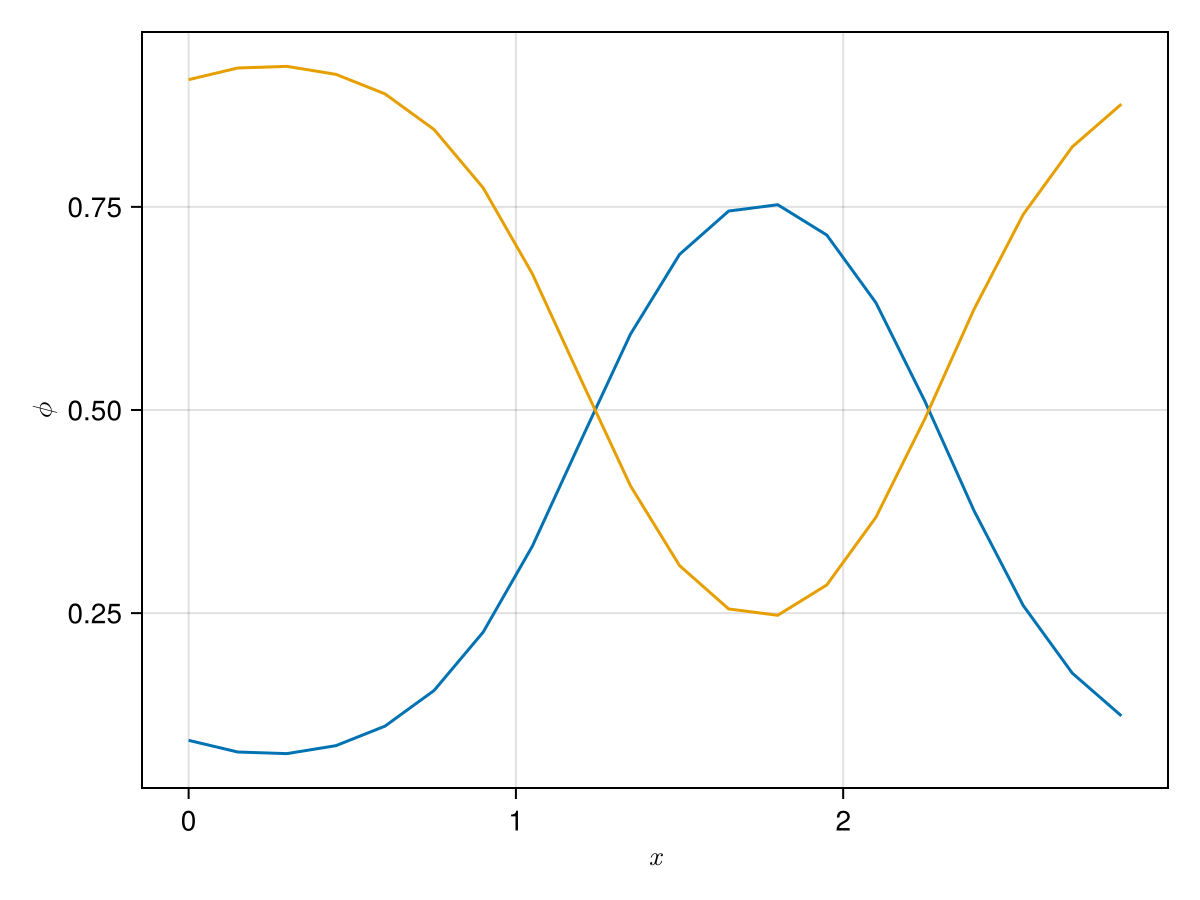

In [217]:
plot_density(scft_AB_lam)

The free energy and other properties can be achieved from the solved model through various methods, such as `F`, `μ`, etc.

In [218]:
JP.F(scft_AB_lam)

2.3619039947774887

In [219]:
JP.lattice(scft_AB_lam)

BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.0] [0]
  * Free lattice parameters: [a]


#### Cell optimization

The cell should be optimized to have zero stress, i.e. the phase separation structure is stress-free. Polyorder provides three ways to optimize the cell with a unified interface function `cell_solve!`:

- **Variable cell optimization**: this is the most recommended way if you know a good initial guess. It optimizes the auxiliary fields and cell shape/size simultaneously. Therefore, it enjoys a fast convergence.
- **Stress-guided cell optimization**: using optimization methods to find the zero-stress unit cell with the aid of the gradient (stress) with respect to cell size and shape. This is a compromising approach to obtain the stress-free solution of the SCFT equations.
- **Gradient-free cell optimization**: it optimizes the unit cell sizes using gradient-free optimization methods. Note that only orthogonal unit cells are supported.

##### Variable cell optimization

To invoke the variable cell optimization mode via `cell_solve!` method, you need to either specify a `VariableCell` updater for the SCFT model or explicitly pass a `VariableCell` updater as an input argument to the `cell_solve!` method.

Note that the initial guess of the cell size is critical to find the equilibrium cell size. Here, by trial and error, we find the equilibrium cell size is about 7.0 $R_g$.

In [220]:
scft_vc = JP.clone(scft_AB_lam)

Noncyclic Chain SCFT model:
* Free energy: 7.3994095805
* Residual: 0.0
* Stress norm: 99990.0
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (20,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: 2.138 [-3.947, 8.257]


In [221]:
JP.cell_solve!(scft_vc, VariableCell(BB(1.0), SIS(1.0)))

[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (stress norm)
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 7.3994095805
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 100000.0
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                  

(Polyorder.Successful(), Noncyclic Chain SCFT model:
* Free energy: 2.33525542
* Residual: 9.959e-6
* Stress norm: 2.03e-6
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.5689129401894397] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (24,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.36 [0.0617, 0.8146]
* First auxiliary field: 2.138 [-4.922, 8.123]
)

In [222]:
JP.F(scft_vc)

2.335255419982708

In [223]:
JP.lattice(scft_vc)

BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.5689129401894397] [0]
  * Free lattice parameters: [a]


##### Stress-guided cell optimization

If you call the `cell_solve!` method with only the SCFT model, i.e. no `VariableCell` updater is given as an input argument and the `updater` field of the SCFT model is not a `VariableCell` instance, then the stress-guided cell optimization is invoked.

In [224]:
scft_sgc = JP.clone(scft_AB_lam)

Noncyclic Chain SCFT model:
* Free energy: 722.5334111006
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (20,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: 2.138 [-3.947, 8.257]


In [225]:
scft_sgc.updater  # updater is PicardMann (alias for SD) not VariableCell

PicardMann iteration with α=0.2.

In [226]:
JP.cell_solve!(scft_sgc)

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 722.5334111006
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 9.93650703051685e-6
[ Info: Stop triggered by EarlyStopping.Threshold(1.0e-5) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619039948
[ Info: final loss: 9.94e-6
[ Info: final stress norm: 0.09399203653342125
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: iterations: 1
[ Info: time per iteration: 248 microseconds, 959 nanoseconds
[ Info: Run time: 00:00:00.000248959
[ In

[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 721.2433588793
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [5.349800904903345]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.4004884123                                                                 
resediual norm: 0.188                                                           
number: 200                                                                     
F: 2.3993211223                                                                 
resediual norm: 0.0122                                                          
number: 300                                                                     
F: 2.3993204311                                                                 
resediual norm: 0.00098

[ Info: final F: 2.3389419172
[ Info: final loss: 9.87e-6
[ Info: final stress norm: 0.03528692321779755
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.355180071538161]
└   * Angles: [0]
[ Info: iterations: 233
[ Info: time per iteration: 52 microseconds, 834 nanoseconds
[ Info: Run time: 00:00:00.012310375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 2.3389419172
[ Info: initial residual norm: 9.87e-6
[ Info: initial stress norm: 0.0293
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5689541986445543]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3352539895                                                                 
resediual norm: 0.

( * Status: success

 * Candidate solution
    Final objective value:     2.335255e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.58e-02 ≰ 1.0e-04
    |x - x'|/|x'|          = 1.56e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.60e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-04 ≰ 0.0e+00
    |g(x)|                 = 8.65e-06 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    9
    ∇f(x) calls:   9
, Noncyclic Chain SCFT model:
* Free energy: 2.3352554251
* Residual: 9.835e-6
* Stress norm: 8.65e-6
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: Brav

In [227]:
JP.F(scft_sgc) - JP.F(scft_vc)

5.088207633008324e-9

In [228]:
Scattering.edges(JP.unitcell(scft_sgc))[1] - Scattering.edges(JP.unitcell(scft_vc))[1]

4.1258455114601134e-5

##### Gradient-free cell optimization

In [229]:
scft_co = JP.clone(scft_AB_lam);

In [230]:
JP.cell_solve!(OptimGradientFreeCellOpt(), scft_co)

[ Info: UnitCell: 3.0
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 722.646400049
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 9.93650703051685e-6
[ Info: Stop triggered by EarlyStopping.Threshold(1.0e-5) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619039948
[ Info: final loss: 9.94e-6
[ Info: final stress norm: 0.09399203653342125
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: iterations: 1
[ Info: time per iteration: 243 microseconds, 250 nanoseconds
[ Info: Run time: 00

[ Info: final loss: 9.95e-6
[ Info: final stress norm: 0.00026067472298059457
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5705244794040394]
└   * Angles: [0]
[ Info: iterations: 216
[ Info: time per iteration: 51 microseconds, 173 nanoseconds
[ Info: Run time: 00:00:00.011053416
[ Info: =======================================
[ Info: UnitCell: 3.5686982763118555
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 2.3352560037
[ Info: initial residual norm: 9.95e-6
[ Info: initial stress norm: 0.000261
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5686982763118555]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 9.500564059461425e-6
[ Info: Stop triggered by EarlyStopping.Threshold(1.0e-5) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info

(Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [2.236068, 4.236068]
 * Minimizer: 3.569055e+00
 * Minimum: 2.335255e+00
 * Iterations: 7
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-04*|x|+2.2e-16): true
 * Objective Function Calls: 8, Noncyclic Chain SCFT model:
* Free energy: 2.3352553413
* Residual: 9.862e-6
* Stress norm: 0.000115
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.569616381505745] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (24,)
* Contour steps: 0.01
* MDE solvers: Di

In [231]:
JP.F(scft_co) - JP.F(scft_vc)

-7.86673877151145e-8

In [232]:
Scattering.edges(JP.unitcell(scft_co))[1] - Scattering.edges(JP.unitcell(scft_vc))[1]

0.0007034413163053976

#### Exercises

1. Compute the free energies of the LAM phase for the same system with χN=20.0 and fA=[0.36, 0.38, 0.40, 0.42].

### HEX

To compute the hexagonal cylinder phase, we construct a simulation cell with simple hexagonal unit cell an space group 17. The space group is used by symmetrizing functionality of Polyorder if enabled.

In [233]:
scft_AB_hex = let
	ds = 0.01
	uc = UnitCell(Hexagonal2D(), 3.6)  # A simple cell with side length 3.6 Rg
	lat = BravaisLattice(uc, 17)  # space group No.17
	system = AB_system(χN=15.0, fA=0.36)
	NoncyclicChainSCFT(system, lat, ds)
end;

In [234]:
let
	scftconfig = SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
    config = Polyorder.Config(scft=scftconfig)
	JP.solve!(scft_AB_hex, config)
end

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 721.2432974961
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3672300315                                                                 
resediual norm: 1.33                                                            
number: 200                                                                     


F: 2.3276797756                                                                 
resediual norm: 0.0123                                                          
[ Info: final loss: 0.0009971289264092825
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3276900746
[ Info: final loss: 0.000997
[ Info: final stress norm: 0.029823685734878706
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: iterations: 285
[ Info: time per iteration: 636 microseconds, 15 nanoseconds
[ Info: Run time: 00:00:00.181264458
[ Info: =======================================


Polyorder.Successful()

Plot the density field of any component, and verify that the hexagonal cylinder phase is actually being computed. If not, you have to go back to the above procedure, change the cell size or disable symmetrizer or initialize by a perpared hexagonal cylinder phase.

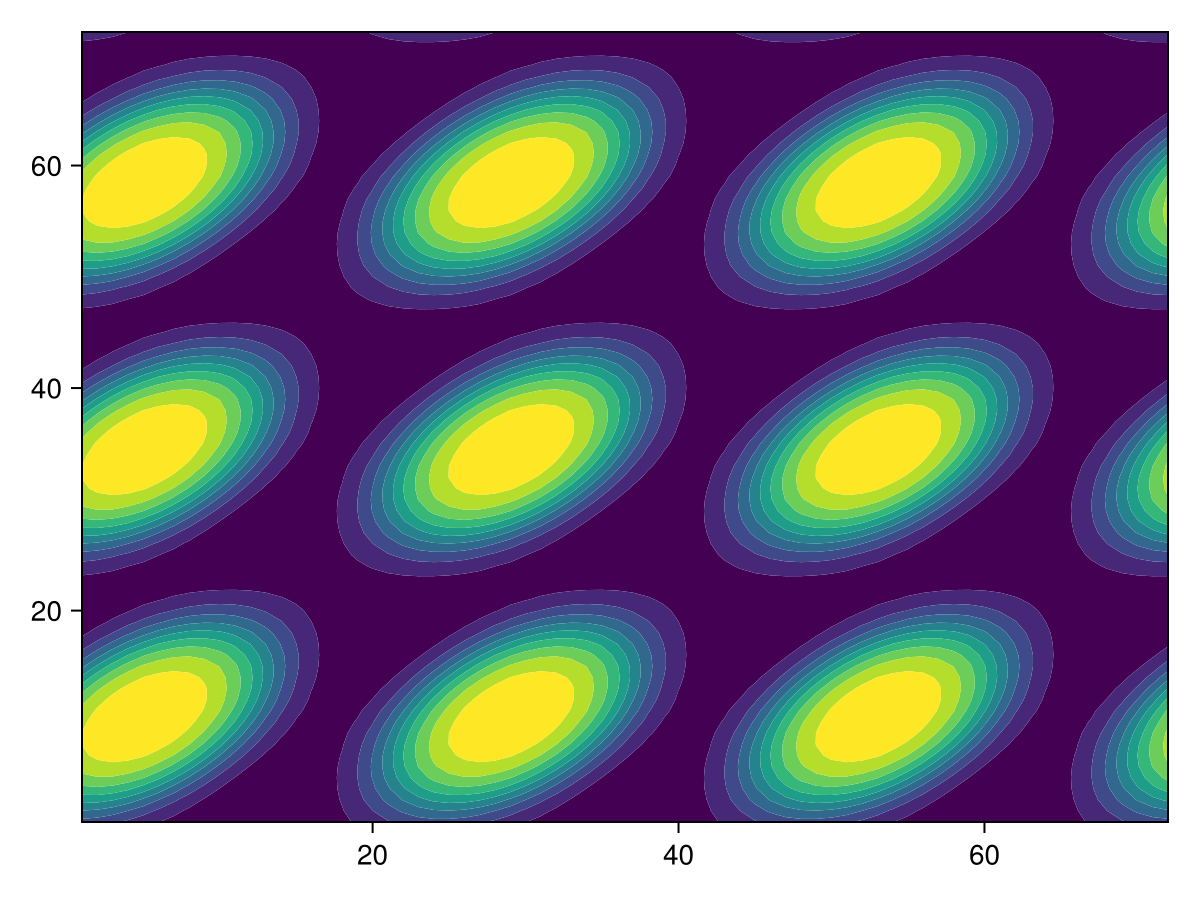

In [235]:
plot_density(scft_AB_hex)

Optimize the simulation cell:

In [236]:
let
	scftconfig = SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
    config = Polyorder.Config(scft=scftconfig)
	scft = JP.clone(scft_AB_hex)
	JP.cell_solve!(scft, VariableCell(BB(1.0), SD(0.2)), config)
end

[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (stress norm)
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 721.2406126917
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                

[ Info: final loss: 0.00015979933162668658
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.315093837
[ Info: final loss: 0.00016
[ Info: final stress norm: 1.91e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.030709535789755, 4.030709535789755]
└   * Angles: [2π/3, 0]
[ Info: iterations: 141
[ Info: time per iteration: 5 milliseconds, 383 microseconds, 40 nanoseconds
[ Info: Run time: 00:00:00.759008709
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.030709535789755, 4.030709535789755]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.315093837047688
[ Info: Final loss: 0.000159799

(Polyorder.Successful(), Noncyclic Chain SCFT model:
* Free energy: 2.315093837
* Residual: 0.0001598
* Stress norm: 1.907e-6
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #17 (p6mm)
  * Crystal system: Hexagonal2D
  * Unit cell: [4.030709535789755, 4.030709535789755] [2π/3, 0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (27, 27)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.36 [0.0831, 0.9312]
* First auxiliary field: 2.095 [-6.

#### Exercises

1. Compute the free energies of the HEX phase for the same system with χN=20.0 and fA=[0.36, 0.38, 0.40, 0.42].